## Applied Machine Learning Homework 3 Task 4

Peter Grantcharov (pdg2116), Po-Chieh Liu (pl2441)

**The overall goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.**

In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Task 4: Any model
1. Create derived features and perform more in-depth preprocessing and data cleaning. 
2. Does thisimprove your model? In particular, think about how to encode categorical variables

### Import data

Based on Task 1, 2, and 3 results

In [2]:
# Selected features
col  = ['Recipient_State',
        'Recipient_Country',
        'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
        'Total_Amount_of_Payment_USDollars', 
        'Date_of_Payment', 
        'Form_of_Payment_or_Transfer_of_Value',
        'Dispute_Status_for_Publication', 
        'Related_Product_Indicator',
        'Covered_or_Noncovered_Indicator_1',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
        'Covered_or_Noncovered_Indicator_2',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
        'Covered_or_Noncovered_Indicator_3',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
       ]

# import file 1 and 2
file1 = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv', usecols = col)
file2 = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv', usecols = col)

# Labeling
file1['y'] = int(0)
file2['y'] = int(1)

# combine (vertical stack)
df = pd.concat([file1, file2], sort = False)

# free memory
del file1, file2, col

# convert to datatime type and reduce to month only
df['Date_of_Payment'] = pd.to_datetime(df.Date_of_Payment, format = "%m/%d/%Y")
df['Date_of_Payment'] = pd.DatetimeIndex(df['Date_of_Payment']).month


### Deal with missing data

In [3]:
# Labelling all missing states as "Unknown"
df.Recipient_State[df.Recipient_State.isnull()] = 'Unknown'

# Grouping all non-us countries and United States Minor Outlying Islands together
df.Recipient_Country[~(
    (df.Recipient_Country == 'United States') |  (df.Recipient_Country.isnull()))] = 'Other'

# assign missing country as unknown country
df.Recipient_Country[df.Recipient_Country.isnull()] = 'Unknown'

# Assign not applicable for missing value
df.Covered_or_Noncovered_Indicator_1[df.Covered_or_Noncovered_Indicator_1.isnull()] = 'M1'
df.Covered_or_Noncovered_Indicator_2[df.Covered_or_Noncovered_Indicator_2.isnull()] = 'M2'
df.Covered_or_Noncovered_Indicator_3[df.Covered_or_Noncovered_Indicator_3.isnull()] = 'M3'

# if the Related_Product_Indicator indicator is Yes, then at least 1 item should be related
# so assume the missing of 1st indicator is missing
for i in range(1, 4):
    name = 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_' + str(i)
    df[name][( (df.Related_Product_Indicator == 'Yes') & (df[name].isnull()))] = 'Unknown' + str(i)

    # The missing indicator 1 with No of related indicator should be NA
    df[name][((df.Related_Product_Indicator == 'No'))] = 'NA' + str(i)


## Build model

In [66]:
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate

#### Metrics

In [86]:
# metric we want to use
scoring = {'balanced_accuracy' : 'balanced_accuracy',
           'precision' : 'precision',
           'average_precision' : 'average_precision', 
           'recall' : 'recall',
           'f1' : 'f1'}

#### Target-based encoding

In [6]:
def target_encoding(df, by, on):
    on_mean = df.groupby(by)[on].mean()
    return df[by].map(on_mean)

In [20]:
# make a copy
df_t = df.copy()

# list
temp_ = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
         'Covered_or_Noncovered_Indicator_2',
         'Covered_or_Noncovered_Indicator_3',
         'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
         'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3']

# target encoding
for el in temp_:
    df_t[el] = target_encoding(df_t, by = el, on = 'y')

## Support Vector Machine

In [21]:
# list 
col = [el for el in df.columns if (el != 'y') ]

# random sub-sample of dataset
rand = np.random.choice(df.index.values, int(len(df) * 0.005))
s_df = df_t.ix[rand]

# subset features
X = s_df.loc[:, col]
y = s_df.loc[:,'y']

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1, 
                                                    stratify = y, 
                                                    train_size = 0.75)

In [22]:
# categorical list 
ct_ls = [x for x in col if (
    (x != 'Total_Amount_of_Payment_USDollars') &
    (x != 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID') &
    (x != 'Covered_or_Noncovered_Indicator_2') &
    (x != 'Covered_or_Noncovered_Indicator_3') &
    (x != 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2') &
    (x != 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3'))]

# continuous list
cts_ls = [x for x in col if x not in ct_ls]

#### Build Pipeline

In [23]:
# PowerTransformer() also standardize the data 
preprocess = make_column_transformer(
    (PowerTransformer(), cts_ls),
    (OneHotEncoder(sparse = False, handle_unknown='ignore'), ct_ls),
    remainder='passthrough')

# logistic pipe
LinearSVC_pipe = make_pipeline(preprocess, LinearSVC(dual = False))

In [98]:
# parameter to tune
param_grid = {'linearsvc__C' : np.logspace(-1, 3, 5)}

# set grid
grid = GridSearchCV(
    LinearSVC_pipe,
    param_grid = param_grid, 
    cv = 5,
    scoring = scoring,
    refit = False)

# searching
_ = grid.fit(X_train, y_train)


In [55]:
for el in grid.cv_results_.keys():
    if ('mean_test_' in el) or ('mean_train' in el):
        print(el + ' : ' + str(grid.cv_results_[el].mean()))

mean_test_balanced_accuracy : 0.8647114703877687
mean_train_balanced_accuracy : 0.8678061764526618
mean_test_precision : 0.8190903722811484
mean_train_precision : 0.8222443172681959
mean_test_average_precision : 0.875435947401374
mean_train_average_precision : 0.8798517831800238
mean_test_recall : 0.746787076991484
mean_train_recall : 0.7527528089887641
mean_test_f1 : 0.7811950720119947
mean_train_f1 : 0.7859641689850472


## Decision Tree Classifier

In [56]:
# columns need transformation
label_col = [x for x in X_train.columns if x != 'Total_Amount_of_Payment_USDollars']

# make a copy
X_train_labeled = X_train.copy()

# transform
for el in label_col:
    X_train_labeled[el] = LabelEncoder().fit_transform(X_train_labeled[el])

In [58]:
# define param grid for grid search
param_grid1 = {'max_depth' : range(4, 15, 2)}
param_grid2 = {'max_leaf_nodes' : range(2, 62, 5)}

# grid searches
dt = DecisionTreeClassifier(random_state = 0)
grid1 = GridSearchCV(dt, param_grid = param_grid1, 
                    cv = 5, scoring = scoring,
                    refit = False)
grid2 = GridSearchCV(dt, param_grid = param_grid2, 
                    cv = 5, scoring = scoring,
                    refit = False)
# searching
_ = grid1.fit(X_train_labeled, y_train)
_ = grid2.fit(X_train_labeled, y_train)

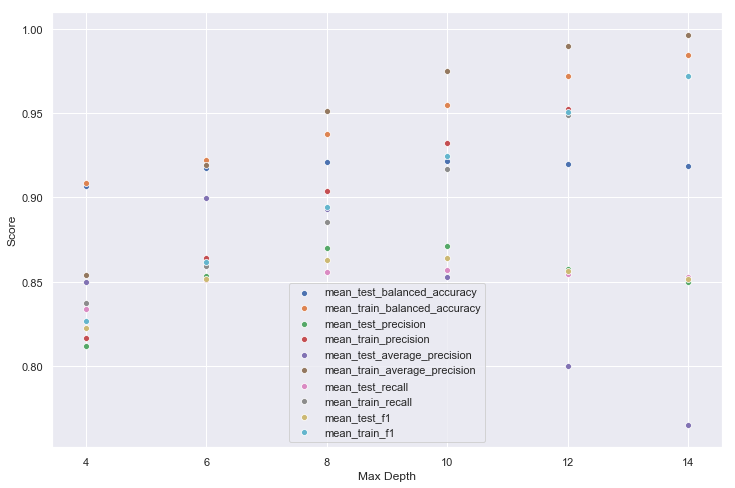

In [62]:
"""
Visualize the effect of max depth on scores
"""
plt.figure(figsize=(12,8))
for el in grid1.cv_results_.keys():
    if ('mean_test' in el) or ('mean_train' in el):
        sns.scatterplot(x = range(4, 15, 2), 
                        y= grid1.cv_results_[el], 
                        label = el)
sns.set(font_scale=1)
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.show()

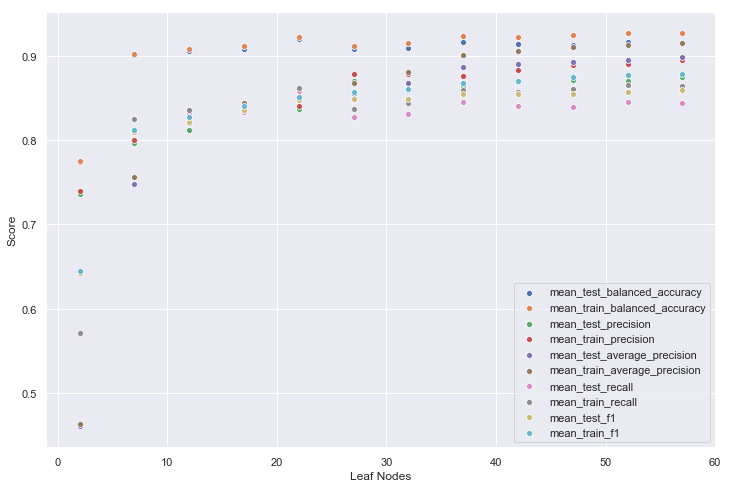

In [60]:
"""
Visualize the effect of leaf nodes on scores
"""
plt.figure(figsize=(12,8))
for el in grid2.cv_results_.keys():
    if ('mean_test' in el) or ('mean_train' in el):
        sns.scatterplot(x = range(2, 62, 5), 
                        y= grid2.cv_results_[el], 
                        label = el)
sns.set(font_scale=1.3)
plt.xlabel("Leaf Nodes")
plt.ylabel("Score")
plt.show()

By observing these visualizations, we can see that the test scores peak at a max depth of about 8 before it starts getting significantly overfit. Similarly, for the leaf nodes, there is a plateau at around 38 nodes, after which some test scores start seeing a slow decline. We will therefore use these two values when assessing this model.

In [89]:
s = cross_validate(DecisionTreeClassifier(random_state = 0, 
                                          max_depth=8,
                                          max_leaf_nodes=38), 
                   X=X_train_labeled, y=y_train, scoring=scoring, cv=3)

score_list = ['test_balanced_accuracy', 'test_precision', 'test_average_precision', 'test_recall', 'test_f1']
for score in score_list:
    print("{s}: {v}".format(s=score, v=s[score].mean()))

test_balanced_accuracy: 0.9054942991245629
test_precision: 0.87133171922319
test_average_precision: 0.8861994127257433
test_recall: 0.8238175815880368
test_f1: 0.8467556494665823


## Random Forest Classifier


In [100]:
"""
# define grid values
param_grid = {'max_depth' : [2, 5, 10],
              'n_estimators' : [50, 100, 200, 300]}

# grid search
grid = GridSearchCV(
    RandomForestClassifier(random_state = 0),
    param_grid = param_grid, 
    cv = 5,
    scoring = scoring,
    refit = False)

# searching
_ = grid.fit(X_train_labeled, y_train)
"""
# define param grid for grid search
param_grid1 = {'max_depth' : [2, 5, 10]}
param_grid2 = {'n_estimators' : [50, 100, 200, 300]}

# grid searches
rf = RandomForestClassifier(random_state = 0)
grid1 = GridSearchCV(rf, param_grid = param_grid1, 
                    cv = 5, scoring = scoring,
                    refit = False)
grid2 = GridSearchCV(rf, param_grid = param_grid2, 
                    cv = 5, scoring = scoring,
                    refit = False)
# searching
_ = grid1.fit(X_train_labeled, y_train)
_ = grid2.fit(X_train_labeled, y_train)

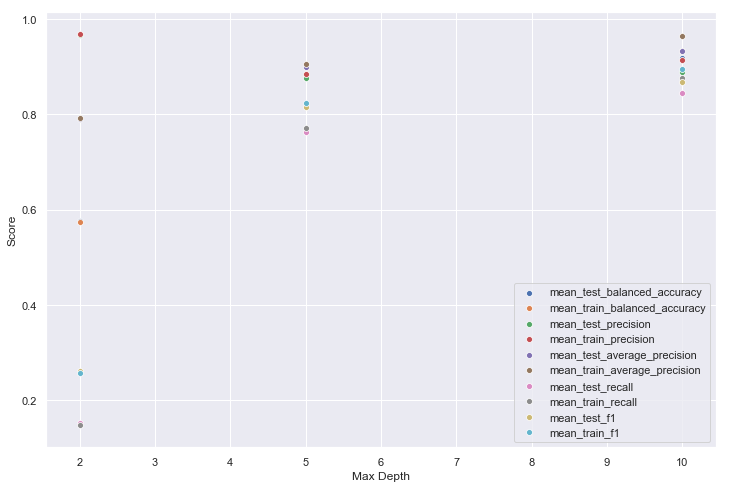

In [101]:
"""
Visualize the effect of max depth on scores
"""
plt.figure(figsize=(12,8))
for el in grid1.cv_results_.keys():
    if ('mean_test' in el) or ('mean_train' in el):
        sns.scatterplot(x = [2, 5, 10], 
                        y= grid1.cv_results_[el], 
                        label = el)
sns.set(font_scale=1)
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.show()

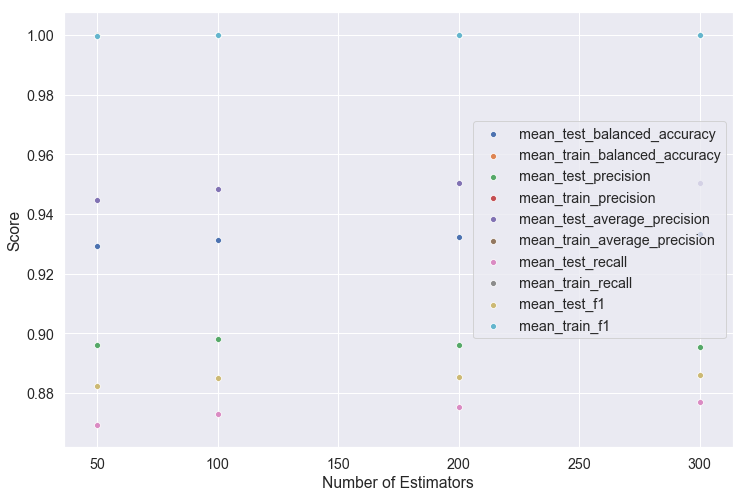

In [104]:
"""
Visualize the effect of n_estimators on scores
"""
plt.figure(figsize=(12,8))
for el in grid2.cv_results_.keys():
    if ('mean_test' in el) or ('mean_train' in el):
        sns.scatterplot(x = [50, 100, 200, 300], 
                        y= grid2.cv_results_[el], 
                        label = el)
sns.set(font_scale=1.3)
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.show()

In [105]:
s = cross_validate(RandomForestClassifier(random_state = 0, 
                                          max_depth=10,
                                          n_estimators=300), 
                   X=X_train_labeled, y=y_train, scoring=scoring, cv=3)

score_list = ['test_balanced_accuracy', 'test_precision', 'test_average_precision', 'test_recall', 'test_f1']
for score in score_list:
    print("{s}: {v}".format(s=score, v=s[score].mean()))

test_balanced_accuracy: 0.9196405058312008
test_precision: 0.8901875425825274
test_average_precision: 0.9400198067890663
test_recall: 0.8503347916094898
test_f1: 0.8697891698064052


# Conlusion for Task 4

In this task, we first performed further cleaning and pre-processing of the data, and then explored three different models for fitting the data in our classification problem. The most significant difference made from the prior tasks was the addition of a target-based encoding for the five categorical variables that we found it to be useful for. The three models tested were:

1. Support Vector Machine
2. Decision Tree
3. Random Forest 

The same sub-sample was used to fit all three models, with label encoding being performed on the categorical variables for models 2 and 3. Grid-search and cross validation was performed, and the resulting scores were compared between the models to see which would perform the best. 

All models were quite effective compared to the baseline Logistic Regression. The Decision Tree and Random Forest classifiers were both quite effective, distinguishing themselves from SVM after getting the best parameters through grid search. The test set scores were noticably better for the Random Forest than Decision Tree, however, it should be noted that for the selected hyperparameters, this came at a significant time cost. Given the training time and enhanced interpretability of the Decision Tree classfier, we have decided to move forward with this model for Task 5. 